In [3]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import mloop.utilities as mlu
import numpy as np

def read(dir): #Get File structure for more accurate
    mat = io.loadmat(dir)
    return mat


def getCost(training_filename):
    training_dict = mlu.get_dict_from_file(
        training_filename,
    )
    all_cost = mlu.safe_cast_to_array(training_dict['in_costs'])
    paramsList = np.array(training_dict['out_params'], dtype=float) 

    return all_cost, paramsList

def getExpData(indstart, indend, dataOut):
    dataRb = dataOut['dataRb']
    for i, runNum in enumerate(dataRb[:, 0]):
        if str(runNum[0]) == str(indstart):
            start = i
        elif str(runNum[0]) == str(indend):
            end = i

    pkOd = np.array(dataRb[start:end, 3], dtype = float)
    NRb = np.array(dataRb[start:end, 8], dtype = float)
    Temp = np.array(dataRb[start:end, 9], dtype = float)
    sigX = np.array(dataRb[start:end, 4], dtype = float)
    sigY = np.array(dataRb[start:end, 5], dtype = float)

    return pkOd, NRb, Temp, sigX, sigY
dirYes = "Z:\KRbLab\\M_loop\\2022_09\\2022-09-22\summary_data_backup.mat"
dataOutYes = read(dirYes)
pkODDay1, NRbDay1, TempDay1, sigXDay1, sigYDay1 = getExpData(50, 204, dataOutYes)
dirTod = "Z:\KRbLab\\M_loop\\2022_09\\2022-09-23\summary_data_backup.mat"
dataOutTod = read(dirTod)
pkODDay2, NRbDay2, TempDay2, sigXDay2, sigYDay2 = getExpData(2, 348, dataOutTod)


cost, paramsList = getCost('../M-LOOP_archives/controller_archive_2022-09-22_21-00.txt')


In [5]:
pkOD =  np.concatenate((pkODDay1, pkODDay2) )
NRb = np.concatenate((NRbDay1, NRbDay2))
Temp = np.concatenate((TempDay1, TempDay2))
n = np.arange(1, len(Temp)+1)
print(len(n))
print(len(cost))
print(len(Temp))

500
500
500


In [31]:
#Finding Minimum Parameters 
paramMin = [10.69300604,  8.46269222,  5.97203474,  3.45242962,  2.16465918]


Amplitudes = [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
ARF = [0.15, 0.1, 0.15, 0.1, 0.05]
writeFileLoc = "Z:\KRbLab\M_Loop1.5\MLoopParam\param.mat"
Time = 16
def write(count, params):
    #Input Fcut (length = 5) tTotal (scalar) amp (length = 5) A (length = 15)
    io.savemat(writeFileLoc,{'count': count, 'fcut':params[0:5], 'tTotal': Time, 'amp': ARF, 'A': Amplitudes})

write(12, paramMin)

Text(0.5, 0, 'pkOD')

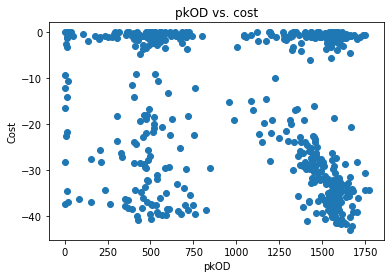

In [45]:
plt.title('pkOD vs. cost')
plt.scatter(pkOD, cost)
plt.ylabel('Cost')
plt.xlabel('pkOD')



Text(0, 0.5, 'Cost')

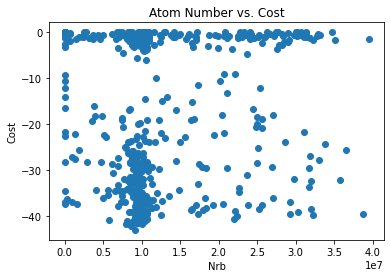

In [46]:
plt.title('Atom Number vs. Cost')
plt.scatter(NRb, cost)
plt.xlabel('Nrb')
plt.ylabel('Cost')



Text(0.5, 0, 'Temp')

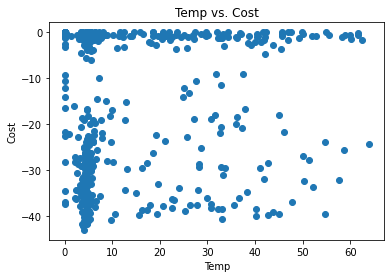

In [47]:
plt.title('Temp vs. Cost')
plt.scatter(Temp, cost)
plt.ylabel('Cost')
plt.xlabel('Temp')


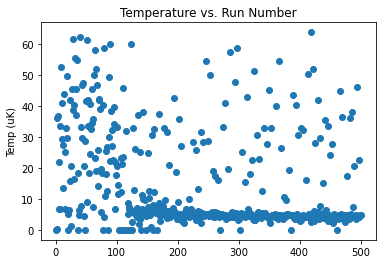

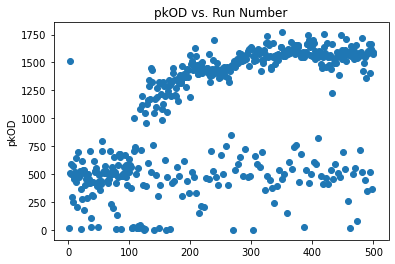

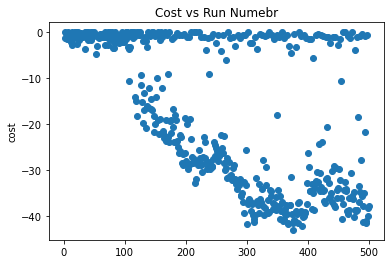

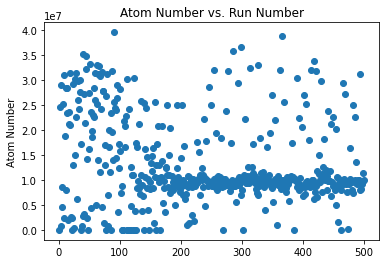

In [48]:

#plt.plot(n, pkOD)
#plt.plot(n, NRb)
plt.title('Temperature vs. Run Number')
plt.ylabel('Temp (uK)')
plt.scatter(n, Temp)
plt.show()
plt.title('pkOD vs. Run Number')
plt.ylabel('pkOD')
plt.scatter(n, pkOD)
plt.show()
plt.title('Cost vs Run Numebr')
plt.scatter(n, cost)
plt.ylabel('cost')
plt.show()



plt.title('Atom Number vs. Run Number')
plt.ylabel('Atom Number')
plt.scatter(n, NRb)
plt.show()


[10.54119461, 4.9748205, 3.25308527, 2.06068179, 1.84569306]


In [49]:
from scipy import integrate

def costFinderODAvg( pkOD, sigX, sigY):
    twoDgauss = lambda y, x: pkOD*np.exp(-(x**2/(2*sigX**2) + y**2/(2*sigY**2)))

    Avg = integrate.dblquad(twoDgauss, -3*sigX, 3*sigX, -3*sigY, 3*sigY)[0]
    return -Avg

CostV2 = []
for i, _ in enumerate(pkOD):
    CostV2.append(costFinderODAvg(pkOD[i], sigX[i], sigY[i]))
CostV2 = np.array(CostV2)

plt.plot(n, CostV2)
IndexV2 = np.where(np.isinf(CostV2), np.Inf,CostV2).argmin()

print(paramsList[IndexV2])
print(NRb[IndexV2])
print(Temp[IndexV2])
print(pkOD[IndexV2])

IndexError: index 226 is out of bounds for axis 0 with size 226

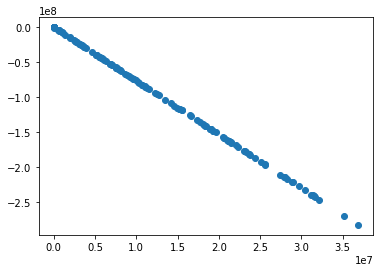

In [102]:
plt.scatter(NRb, CostV2)

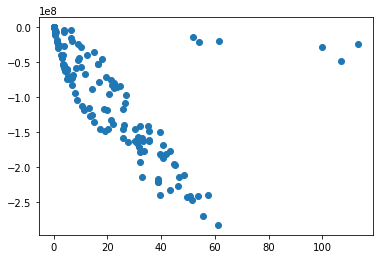

In [103]:
plt.scatter(Temp, CostV2)

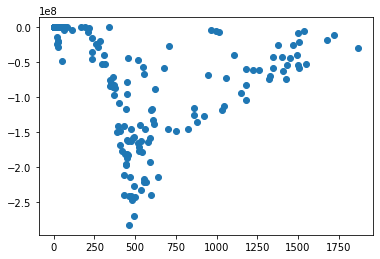

In [104]:
plt.scatter(pkOD, CostV2)

In [105]:

from scipy import integrate


def costFinderpkOD(pkOD):
    return -pkOD*(1/100)
CostV3 = []
for i, _ in enumerate(pkOD):
    CostV3.append(costFinderpkOD(pkOD[i]))
CostV3 = np.array(CostV3)


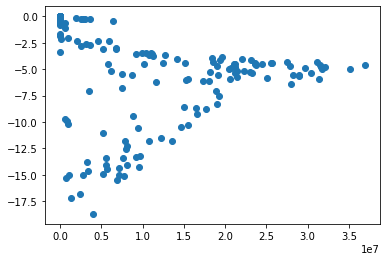

In [112]:
plt.scatter(NRb, CostV3)
#plt.xscale('log')


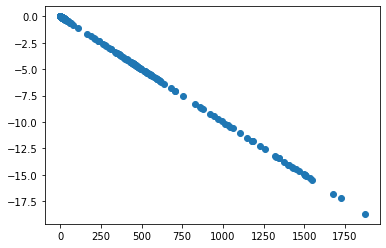

In [108]:
plt.scatter(pkOD, CostV3)

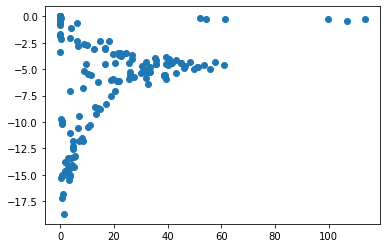

In [109]:
plt.scatter(Temp, CostV3)

<ipython-input-14-51f78d8a99ce>:6: RuntimeWarning: overflow encountered in exp
  Fn = 2/(1 + np.exp(N1/NRb))


In [61]:
import pandas as pd
from rich.console import Console
from rich.table import Table

N1 = 7376000.0*5
alpha = -9/5
def costFinderLit(pkOD, NRb, alpha): #Background N Get File structure for more accurate
    if NRb <= 0:
        return 0
    else:
        Fn = 2/(1 + np.exp(N1/NRb))
        return -Fn*pkOD**3*NRb**(alpha-9/5) *1E7
CostV4 = np.zeros(len(pkOD))
for i, _ in enumerate(pkOD):
    CostV4[i] = costFinderLit(pkOD[i], NRb[i], alpha)


numOfminimum = 25
d = {'minNum': [], 'cost':[], 'N': [], 'pkOD': [], 'T': [], 'param': []}

inds = CostV4.argsort()



d['minNum'] = inds[:numOfminimum]
d['cost'] = CostV4[inds[:numOfminimum]]
d['N'] = NRb[inds[:numOfminimum]]
d['pkOD'] = pkOD[inds[:numOfminimum]]
d['T'] = Temp[inds[:numOfminimum]]
for i in range(numOfminimum):
    d['param'].append(paramsList[inds[i]])
df = pd.DataFrame(data=d)
print(paramsList[362])
df.sort_values('T')


[10.69300604  8.46269222  5.97203474  3.45242962  2.16465918]


<ipython-input-61-da927218f147>:11: RuntimeWarning: overflow encountered in exp
  Fn = 2/(1 + np.exp(N1/NRb))


,minNum,cost,N,pkOD,T,param
17,324,-1.307515e-10,7317000.0,1736.2,3.172,"[19.57523296, 9.37570875, 18.42469858, 9.74767..."
0,392,-1.471017e-10,7955000.0,1746.5,3.426,"[5.58488598, 17.90861473, 14.17975211, 12.4867..."
2,480,-1.406123e-10,8020000.0,1715.9,3.508,"[6.6933819, 6.14049353, 17.90833838, 18.341108..."
10,364,-1.350747e-10,8140000.0,1685.4,3.621,"[13.53267417, 15.5153624, 10.74586346, 12.0490..."
11,323,-1.325200e-10,8189000.0,1671.8,3.671,"[10.56303619, 8.41866624, 5.48952705, 3.215527..."
1,394,-1.413364e-10,8343000.0,1699.5,3.687,"[10.36037798, 8.62113833, 5.76046265, 3.532073..."
6,335,-1.375416e-10,8522000.0,1675.6,3.820,"[10.69997956, 8.59168903, 5.8559277, 3.3541937..."
13,371,-1.324205e-10,8443000.0,1658.1,3.835,"[10.73564432, 8.62148431, 6.15559081, 3.344781..."
7,390,-1.364898e-10,8569000.0,1669.3,3.848,"[10.53619375, 8.47694717, 5.85975221, 3.415951..."
18,398,-1.306246e-10,8518000.0,1647.2,3.883,"[10.14863941, 8.79059853, 5.78558515, 3.606651..."


In [ ]:
#Finding Minimum Parameters 
paramMin = [10.69300604,  8.46269222,  5.97203474,  3.45242962,  2.16465918]


Amplitudes = [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
ARF = [0.15, 0.1, 0.15, 0.1, 0.05]
writeFileLoc = "Z:\KRbLab\M_Loop1.5\MLoopParam\param.mat"
Time = 16
def write(count, params):
    #Input Fcut (length = 5) tTotal (scalar) amp (length = 5) A (length = 15)
    io.savemat(writeFileLoc,{'count': count, 'fcut':params[0:5], 'tTotal': Time, 'amp': ARF, 'A': Amplitudes})

write(12, paramMin)

In [1]:
#Plotting Sequences
#Plots Original ramp Sequence
def seqNormal():
    f0 = 20
    fb = 1.785
    fcut = [10, 5, 3, 2.3, 2.21]
    tau = [3.5, 4, 5, 5, 2]
    fstart=fcut[0:len(fcut)-1]
    fstart.insert(0, f0)
    tstage=-np.array(tau)*np.log((np.array(fcut)-fb)/(np.array(fstart)-fb))
    freq = []
    time = []
    t = 0
    for i in range(0, len(tau)):

        Nj=300;
        dt=tstage[i]/Nj;
        for j in range(0, Nj):
            f=(fstart[i]-fb)*np.exp(-j*dt/tau[i])+fb;
            t = t + dt
            freq.append(f)
            time.append(t)
    return time, freq
def plotRamp(fstart):
    tTotal = 16

    tau = tTotal/len(fstart)*np.ones(len(fstart));
    fstart.insert(0, 20)
    print(fstart)
    set = 0;
    freq = []
    time = []
    t = 0 
    f = 0
    for i in range(0, len(tau)):


        Nj=300 
        dt=tau[i]/Nj;


    
        for j in range(0, Nj):
            #f=(fstart(i)-fb).*exp(-j.*dt./tau(i))+fb;
            f = fstart[i] + (fstart[i+1] - fstart[i])*j*dt/tau[i] #+ A2.*j.*dt.*(j.*dt - tau(i)) + A3.*j.*dt.*(j.*dt-tau(i)).*(j.*dt + 0.5*tau(i)) + A4.*j.*dt.*(j.*dt + 2/3*tau(i)).*(j.*dt + 1/3*tau(i));
            t = t + dt
            freq.append(f)
            time.append(t)
    return time, freq
totalStates = 3
for i in range(totalStates):
    fstart = list(df['param'][i])

    time, freq= plotRamp(fstart)
    plt.plot(time, freq, label=f"N = {df['N'][i]:.1E}")
    
time, freq =   seqNormal()
plt.plot(time, freq, label=f"Normal Ramp")
plt.title(f'Optimal Ramp Sequences from Cost(N1 = {36880000.0:.1E}, alpha = -0.2)')
plt.xlabel('time (sec)')
plt.ylabel('Frequencies (Mhz)')
plt.legend()
plt.show()


NameError: name 'df' is not defined

In [11]:
import pandas as pd
from rich.console import Console
from rich.table import Table



numOfminimum = 25
d = {'minNum': [], 'cost':[], 'N': [], 'pkOD': [], 'T': [], 'param': []}

inds = CostV4.argsort()



d['minNum'] = inds[:numOfminimum]
d['cost'] = CostV4[inds[:numOfminimum]]
d['N'] = NRb[inds[:numOfminimum]]
d['pkOD'] = pkOD[inds[:numOfminimum]]
d['T'] = Temp[inds[:numOfminimum]]
for i in range(numOfminimum):
    d['param'].append(paramsList[inds[i]])
df = pd.DataFrame(data=d)
print(paramsList[362])
df.sort_values('T')


[10.69300604  8.46269222  5.97203474  3.45242962  2.16465918]


,minNum,cost,N,pkOD,T,param
22,391,-0.314709,9166000.0,1663.0,4.138,"[10.37071043, 8.5705567, 5.7021781, 3.22865161..."
19,495,-0.317053,9588000.0,1624.7,4.432,"[10.60615571, 8.45747961, 5.85884632, 3.412328..."
23,360,-0.314183,9603000.0,1618.4,4.461,"[17.04512832, 18.33368383, 11.57925391, 6.5614..."
4,376,-0.337406,9812000.0,1638.4,4.499,"[11.94750981, 2.37636851, 15.94031051, 12.3650..."
11,368,-0.326667,9795000.0,1622.3,4.533,"[13.82722376, 13.65466076, 8.15945235, 4.86710..."
10,300,-0.328747,9901000.0,1616.7,4.587,"[17.86187445, 2.07602512, 6.14568622, 4.104900..."
9,311,-0.328890,10010000.0,1608.0,4.668,"[10.60213235, 8.43813849, 5.76160033, 3.474223..."
8,491,-0.329007,10050000.0,1605.0,4.698,"[10.58856027, 8.69101845, 5.95224689, 3.283144..."
6,367,-0.330905,10070000.0,1606.5,4.705,"[10.63574752, 8.49254961, 5.88543411, 3.346340..."
17,499,-0.320269,10070000.0,1589.1,4.742,"[10.66270387, 8.46991158, 6.01661774, 3.420955..."


In [23]:
def costFinderLit(pkOD, NRb, alpha): #Background N Get File structure for more accurate
    N1 = 7376000.0*4.0#or 7376000.0/100
    if NRb <= 0:
        return 0
    else:
        Fn = 2/(1 + np.exp(N1/NRb))
        return -Fn*pkOD**3*NRb**(alpha-9/5)*1E7
CostV4 = []
for i, _ in enumerate(pkOD):
    CostV4.append(costFinderLit(pkOD[i], NRb[i], -1/5))
CostV4 = np.array(CostV4)



<ipython-input-23-9af39becf692>:6: RuntimeWarning: overflow encountered in exp
  Fn = 2/(1 + np.exp(N1/NRb))


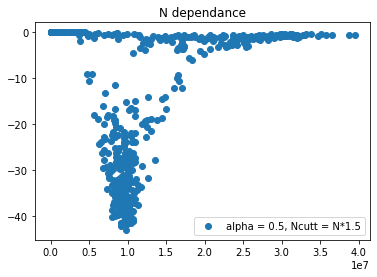

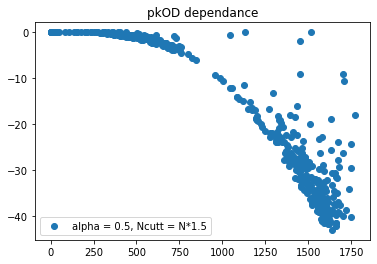

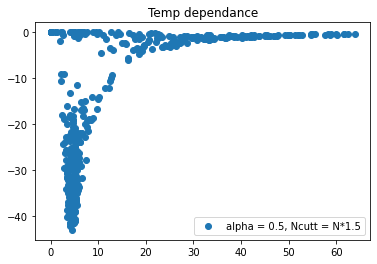

In [24]:

def CostEffect(coster):
    plt.title('N dependance')
    plt.scatter(NRb, coster, label = 'alpha = 0.5, Ncutt = N*1.5')
    plt.legend()
    plt.show()
    plt.title('pkOD dependance')
    plt.scatter(pkOD, coster, label = 'alpha = 0.5, Ncutt = N*1.5')
    plt.legend()
    plt.show()
    plt.title('Temp dependance')
    plt.scatter(Temp, coster, label = 'alpha = 0.5, Ncutt = N*1.5')
    plt.legend()

    plt.show()
#plt.xscale('log')
CostEffect(CostV4)

In [29]:
import pandas as pd
from rich.console import Console
from rich.table import Table



numOfminimum = 25
d = {'minNum': [], 'cost':[], 'N': [], 'pkOD': [], 'T': [], 'param': []}

inds = CostV4.argsort()



d['minNum'] = inds[:numOfminimum]
d['cost'] = CostV4[inds[:numOfminimum]]
d['N'] = NRb[inds[:numOfminimum]]
d['pkOD'] = pkOD[inds[:numOfminimum]]
d['T'] = Temp[inds[:numOfminimum]]
for i in range(numOfminimum):
    d['param'].append(paramsList[inds[i]])
df = pd.DataFrame(data=d)
print(paramsList[362])
print(costFinderLit(1600, 7E7, -1/5))
print(costFinderLit(1746.5, 7955000.0, -1/5))
df.sort_values('T')


[10.69300604  8.46269222  5.97203474  3.45242962  2.16465918]
-43.804523763702974
-40.27195367909531


,minNum,cost,N,pkOD,T,param
18,392,-40.271954,7955000.0,1746.5,3.426,"[5.58488598, 17.90861473, 14.17975211, 12.4867..."
21,394,-39.907472,8343000.0,1699.5,3.687,"[10.36037798, 8.62113833, 5.76046265, 3.532073..."
23,328,-39.876589,8793000.0,1659.7,3.979,"[4.99665244, 13.7955658, 6.92070832, 6.8154891..."
4,496,-41.643395,9098000.0,1661.4,4.101,"[3.33260489, 10.25703401, 7.71592703, 5.125625..."
5,375,-41.577950,9125000.0,1658.7,4.128,"[10.59762128, 8.50216047, 5.84398189, 3.415105..."
1,391,-42.109833,9166000.0,1663.0,4.138,"[10.37071043, 8.5705567, 5.7021781, 3.22865161..."
22,310,-39.886492,9341000.0,1622.3,4.317,"[10.51386223, 8.32502986, 5.39116146, 3.362239..."
11,495,-41.107647,9588000.0,1624.7,4.432,"[10.60615571, 8.45747961, 5.85884632, 3.412328..."
15,360,-40.690982,9603000.0,1618.4,4.461,"[17.04512832, 18.33368383, 11.57925391, 6.5614..."
0,376,-43.044984,9812000.0,1638.4,4.499,"[11.94750981, 2.37636851, 15.94031051, 12.3650..."


(2, 226)
0
1


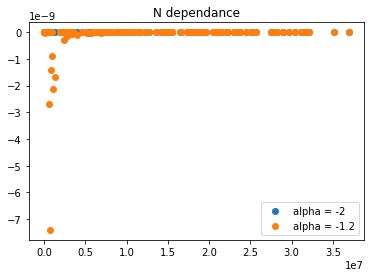

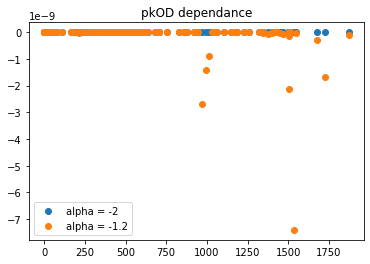

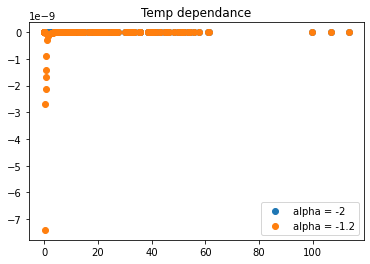

(2, 226)
0
1


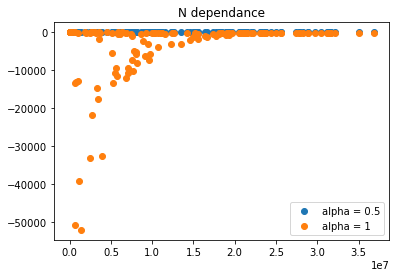

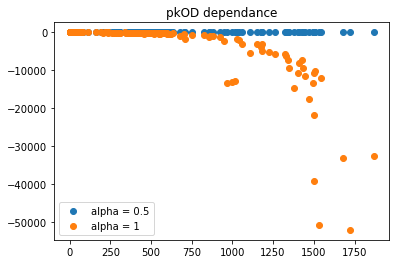

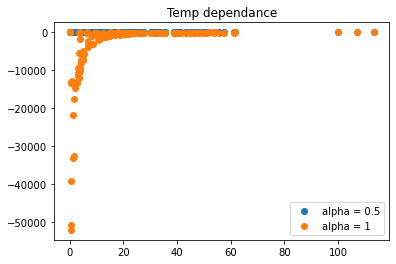

(1, 226)
0


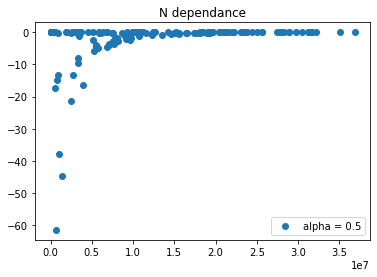

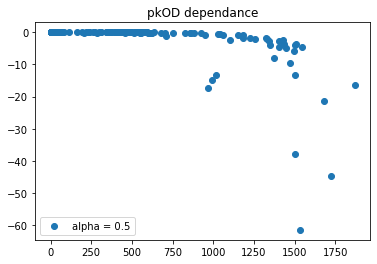

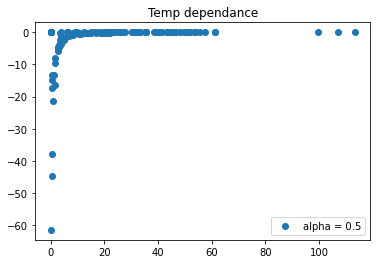

In [47]:
#Plotting Different Alpha

    


def plotAlpha(coster, start):
    print(np.shape(coster))
    plt.title('N dependance')

    for index, i in enumerate(coster):
        print(index)
        plt.scatter(NRb, i, label =f'alpha = {alphaList[start + index]}')

    plt.legend()
    plt.show()
    
    
    plt.title('pkOD dependance')
    for index, i in enumerate(coster):
        plt.scatter(pkOD, i, label =f'alpha = {alphaList[start + index]}')
    plt.legend()
    plt.show()
    
    plt.title('Temp dependance')
    for index, i in enumerate(coster):
        plt.scatter(Temp, i, label =f'alpha = {alphaList[start + index]}')
    plt.legend()
    plt.show()
#plt.xscale('log')

plotAlpha(costArray[0:2], 0)
plotAlpha(costArray[3:5], 3)
plotAlpha([costArray[3]], 3)


0


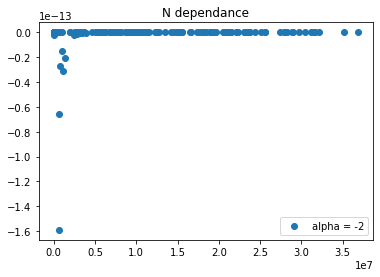

1


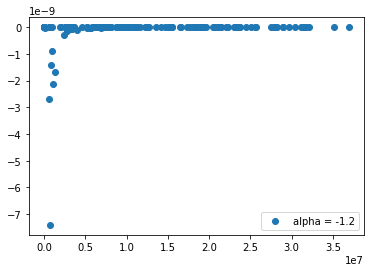

2


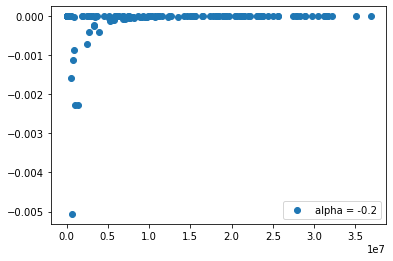

3


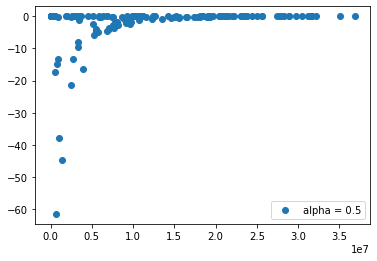

4


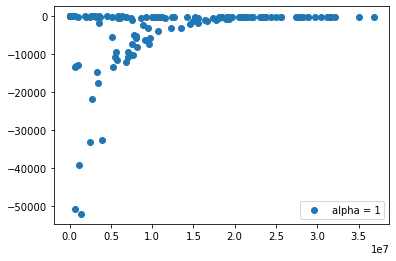

In [48]:
plt.title('N dependance')

for index, i in enumerate(costArray):
    print(index)
    plt.scatter(NRb, i, label =f'alpha = {alphaList[ index]}')
    plt.legend()
    plt.show()


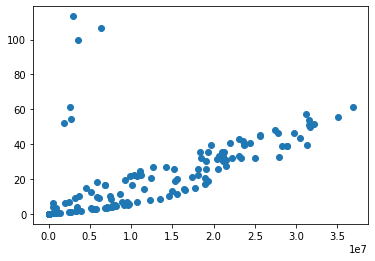

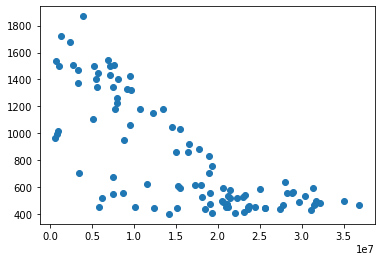

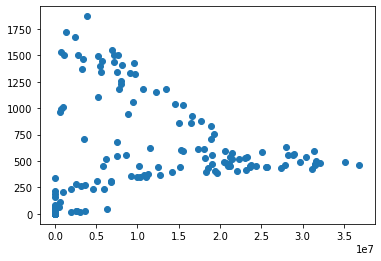

In [73]:
plt.scatter(NRb, Temp)
plt.show()
plt.scatter(NRb[pkOD>400], pkOD[pkOD>400])
plt.show()
plt.scatter(NRb, pkOD)